# Lab 4: Data Imputation using an Autoencoder




In [206]:
%%shell
jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/APS360\ Lab_4_Data_Imputation.ipynb

[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/APS360 Lab_4_Data_Imputation.ipynb to html
[NbConvertApp] Writing 658604 bytes to /content/drive/MyDrive/Colab Notebooks/APS360 Lab_4_Data_Imputation.html


## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1c9k_ZJo-H0NGQp8SEooCuiVsM6piC-tS?usp=sharing

## Part 0

We will be using a package called `pandas` for this assignment. 

If you are using Colab, `pandas` should already be available.
If you are using your own computer,
installation instructions for `pandas` are available here: 
https://pandas.pydata.org/pandas-docs/stable/install.html

In [2]:
import csv
import numpy as np
import random
import torch
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1. Data Cleaning [15 pt]

The adult.data file is available at `https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data`

The function `pd.read_csv` loads the adult.data file into a pandas dataframe.
You can read about the pandas documentation for `pd.read_csv` at
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html

In [5]:
header = ['age', 'work', 'fnlwgt', 'edu', 'yredu', 'marriage', 'occupation',
 'relationship', 'race', 'sex', 'capgain', 'caploss', 'workhr', 'country']
df = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    names=header,
    index_col=False)

In [6]:
df.shape # there are 32561 rows (records) in the data frame, and 14 columns (features)

(32561, 14)

### Part (a) Continuous Features [3 pt]

For each of the columns `["age", "yredu", "capgain", "caploss", "workhr"]`, report the minimum, maximum, and average value across the dataset. 

Then, normalize each of the features `["age", "yredu", "capgain", "caploss", "workhr"]`
so that their values are always between 0 and 1.
Make sure that you are actually modifying the dataframe `df`. 

$z_i = \frac{x_i - min(x)}{max(x) - min(x)}, \hspace{2mm} x = (x_1, x_2, ..., x_n)$

####Max:
$
\begin{array}{ |c c| }
age&&           90\\
yredu&&         16\\
capgain&&    99999\\
caploss  &&   4356\\
workhr     &&   99
\end{array}
$

####Min:
$
\begin{array}{ |c c| }
age&&        17\\
yredu&&       1\\
capgain&&     0\\
caploss  &&   0\\
workhr     && 1
\end{array}
$

####Average:
$
\begin{array}{ |c c| }
age&&          38.581647\\
yredu&&        10.080679\\
capgain&&    1077.648844\\
caploss  &&    87.303830\\
workhr     &&  40.437456
\end{array}
$

In [7]:
cont_features = df[["age", "yredu", "capgain", "caploss", "workhr"]]

In [7]:
cont_features[:10]

,age,yredu,capgain,caploss,workhr
0,39,13,2174,0,40
1,50,13,0,0,13
2,38,9,0,0,40
3,53,7,0,0,40
4,28,13,0,0,40
5,37,14,0,0,40
6,49,5,0,0,16
7,52,9,0,0,45
8,31,14,14084,0,50
9,42,13,5178,0,40


In [8]:
max_features = cont_features.max()
print(max_features)

age           90
yredu         16
capgain    99999
caploss     4356
workhr        99
dtype: int64


In [9]:
min_features = cont_features.min()
print(min_features)

age        17
yredu       1
capgain     0
caploss     0
workhr      1
dtype: int64


In [10]:
avg_features = cont_features.mean()
print(avg_features)

age          38.581647
yredu        10.080679
capgain    1077.648844
caploss      87.303830
workhr       40.437456
dtype: float64


In [11]:
arr = ["age", "yredu", "capgain", "caploss", "workhr"]

for feature in arr:
  df[feature] = (df[feature] - min_features[feature]) / (max_features[feature] - min_features[feature]) 


In [12]:
df

,age,work,fnlwgt,edu,yredu,marriage,occupation,relationship,race,sex,capgain,caploss,workhr,country
0,0.301370,State-gov,77516,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.021740,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,83311,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,215646,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,234721,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,338409,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,Private,257302,Assoc-acdm,0.733333,Married-civ-spouse,Tech-support,Wife,White,Female,0.000000,0.0,0.377551,United-States
32557,0.315068,Private,154374,HS-grad,0.533333,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0.000000,0.0,0.397959,United-States
32558,0.561644,Private,151910,HS-grad,0.533333,Widowed,Adm-clerical,Unmarried,White,Female,0.000000,0.0,0.397959,United-States
32559,0.068493,Private,201490,HS-grad,0.533333,Never-married,Adm-clerical,Own-child,White,Male,0.000000,0.0,0.193878,United-States


### Part (b) Categorical Features [1 pt]

What percentage of people in our data set are male? Note that the data labels all have an unfortunate space in the beginning, e.g. " Male" instead of "Male".

What percentage of people in our data set are female?

In [ ]:
male_percent = float(sum(df["sex"] == " Male")) / float(df.shape[0]) 
print(male_percent)

0.6692054912318418


In [ ]:
female_percent = float(sum(df["sex"] == " Female")) / float(df.shape[0]) 
print(female_percent)

0.33079450876815825


### Part (c) [2 pt]

Before proceeding, we will modify our data frame in a couple more ways:

1. We will restrict ourselves to using a subset of the features (to simplify our autoencoder)
2. We will remove any records (rows) already containing missing values, and store them in a second dataframe. We will only use records without missing values to train our autoencoder.

Both of these steps are done for you, below.

How many records contained missing features? What percentage of records were removed?

There are 1843 records with missing data, which means only about 5.66% of records
were removed

In [13]:
contcols = ["age", "yredu", "capgain", "caploss", "workhr"]
catcols = ["work", "marriage", "occupation", "edu", "relationship", "sex"]
features = contcols + catcols
df = df[features]

In [14]:
missing = pd.concat([df[c] == " ?" for c in catcols], axis=1).any(axis=1)
df_with_missing = df[missing]
df_not_missing = df[~missing]

In [15]:
df_with_missing.shape

(1843, 11)

In [16]:
percent_missing = df_with_missing.shape[0] / df.shape[0]
percent_missing

0.056601455729246644

### Part (d) One-Hot Encoding [1 pt]

What are all the possible values of the feature "work" in `df_not_missing`? You may find the Python function `set` useful.

$
\begin{array}{c}
 ' Federal-gov',\\
 ' Local-gov',\\
 ' Private',\\
 ' Self-emp-inc',\\
 ' Self-emp-not-inc',\\
 ' State-gov',\\
 ' Without-pay'
\end{array}
$

In [48]:
work = set(df_not_missing["work"])
work

{' Federal-gov',
 ' Local-gov',
 ' Private',
 ' Self-emp-inc',
 ' Self-emp-not-inc',
 ' State-gov',
 ' Without-pay'}

In [173]:
data = pd.get_dummies(df_not_missing)

In [174]:
data

,age,yredu,capgain,caploss,workhr,work_ Federal-gov,work_ Local-gov,work_ Private,work_ Self-emp-inc,work_ Self-emp-not-inc,work_ State-gov,work_ Without-pay,marriage_ Divorced,marriage_ Married-AF-spouse,marriage_ Married-civ-spouse,marriage_ Married-spouse-absent,marriage_ Never-married,marriage_ Separated,marriage_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,occupation_ Handlers-cleaners,occupation_ Machine-op-inspct,occupation_ Other-service,occupation_ Priv-house-serv,occupation_ Prof-specialty,occupation_ Protective-serv,occupation_ Sales,occupation_ Tech-support,occupation_ Transport-moving,edu_ 10th,edu_ 11th,edu_ 12th,edu_ 1st-4th,edu_ 5th-6th,edu_ 7th-8th,edu_ 9th,edu_ Assoc-acdm,edu_ Assoc-voc,edu_ Bachelors,edu_ Doctorate,edu_ HS-grad,edu_ Masters,edu_ Preschool,edu_ Prof-school,edu_ Some-college,relationship_ Husband,relationship_ Not-in-family,relationship_ Other-relative,relationship_ Own-child,relationship_ Unmarried,relationship_ Wife,sex_ Female,sex_ Male
0,0.301370,0.800000,0.021740,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,0.136986,0.733333,0.000000,0.0,0.377551,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
32557,0.315068,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1
32558,0.561644,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0
32559,0.068493,0.533333,0.000000,0.0,0.193878,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1


### Part (e) One-Hot Encoding [2 pt]

The dataframe `data` contains the cleaned and normalized data that we will use to train our denoising autoencoder.

How many **columns** (features) are in the dataframe `data`?

Briefly explain where that number come from.

There are 57 features in data. Originally there was only 14, but each column that wasn't continus was expanded to be represented by a one-hot encoding. What this means is that the 'work' column was expanded to 7 columns, each one representing one of the eight work options (all zeros represents 'Never-worked'). This process was repeated for each non-continuous column.
 

### Part (f) One-Hot Conversion [3 pt]

We will convert the pandas data frame `data` into numpy, so that
it can be further converted into a PyTorch tensor.
However, in doing so, we lose the column label information that
a panda data frame automatically stores.

Complete the function `get_categorical_value` that will return
the named value of a feature given a one-hot embedding.
You may find the global variables `cat_index` and `cat_values`
useful. (Display them and figure out what they are first.)

We will need this function in the next part of the lab
to interpret our autoencoder outputs. So, the input
to our function `get_categorical_values` might not 
actually be "one-hot" -- the input may instead 
contain real-valued predictions from our neural network.

In [175]:
datanp = data.values.astype(np.float32)

In [51]:
cat_index = {}  # Mapping of feature -> start index of feature in a record
cat_values = {} # Mapping of feature -> list of categorical values the feature can take

# build up the cat_index and cat_values dictionary
for i, header in enumerate(data.keys()):
    if "_" in header: # categorical header
        feature, value = header.split()
        feature = feature[:-1] # remove the last char; it is always an underscore
        if feature not in cat_index:
            cat_index[feature] = i
            cat_values[feature] = [value]
        else:
            cat_values[feature].append(value)

def get_onehot(record, feature):
    """
    Return the portion of `record` that is the one-hot encoding
    of `feature`. For example, since the feature "work" is stored
    in the indices [5:12] in each record, calling `get_range(record, "work")`
    is equivalent to accessing `record[5:12]`.
    
    Args:
        - record: a numpy array representing one record, formatted
                  the same way as a row in `data.np`
        - feature: a string, should be an element of `catcols`
    """
    start_index = cat_index[feature]
    stop_index = cat_index[feature] + len(cat_values[feature])
    return record[start_index:stop_index]

def get_categorical_value(onehot, feature):
    """
    Return the categorical value name of a feature given
    a one-hot vector representing the feature.
    
    Args:
        - onehot: a numpy array one-hot representation of the feature
        - feature: a string, should be an element of `catcols`
        
    Examples:
    
    >>> get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")
    'State-gov'
    >>> get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")
    'Private'
    """
    return cat_values[feature][np.argmax(onehot)]


In [ ]:
get_categorical_value(np.array([0., 0., 0., 0., 0., 1., 0.]), "work")

In [ ]:
get_categorical_value(np.array([0.1, 0., 1.1, 0.2, 0., 1., 0.]), "work")

In [40]:
# more useful code, used during training, that depends on the function
# you write above

def get_feature(record, feature):
    """
    Return the categorical feature value of a record
    """
    onehot = get_onehot(record, feature)
    return get_categorical_value(onehot, feature)

def get_features(record):
    """
    Return a dictionary of all categorical feature values of a record
    """
    return { f: get_feature(record, f) for f in catcols }

### Part (g) Train/Test Split [3 pt]

Randomly split the data into approximately 70% training, 15% validation and 15% test.

Report the number of items in your training, validation, and test set.

Training set size:  21502 <br>
Validation set size:  4607 <br>
Testing set size:  4609 <br>

In [161]:
def get_data_loader(batch_size=1):
  np.random.seed(50)
  torch.manual_seed(42)

  relevant_indices = list(range(datanp.shape[0]))
  np.random.shuffle(relevant_indices)

  split_1 = int(len(relevant_indices) * 0.7)
  split_2 = int(len(relevant_indices) * 0.15) + split_1

  relevant_train_indices  = relevant_indices[:split_1]
  relevant_val_indices = relevant_indices[split_1:split_2]  
  relevent_test_indices = relevant_indices[split_2:]
  print("First test index", relevent_test_indices[0])

  print("Training set size: ", len(relevant_train_indices))
  print("Validation set size: ", len(relevant_val_indices))
  print("Testing set size: ", len(relevent_test_indices))

  # Get the training samples
  train_sampler = SubsetRandomSampler(relevant_train_indices)
  train_loader = torch.utils.data.DataLoader(datanp, batch_size=batch_size, 
                                              num_workers =1, sampler=train_sampler)

  # Get the validation samples
  val_sampler = SubsetRandomSampler(relevant_val_indices)
  val_loader = torch.utils.data.DataLoader(datanp, batch_size=batch_size, 
                                              num_workers =1, sampler=val_sampler)

  # Get the testing samples
  test_sampler = SubsetRandomSampler(relevent_test_indices)
  test_loader = torch.utils.data.DataLoader(datanp, batch_size=batch_size, 
                                              num_workers =1, sampler=test_sampler)
  
  return train_loader, val_loader, test_loader

In [ ]:
train_loader, val_loader, test_loader = get_data_loader(64)

Training set size:  21502
Validation set size:  4607
Testing set size:  4609


## Part 2. Model Setup [5 pt]

### Part (a) [4 pt]

Design a fully-connected autoencoder by modifying the `encoder` and `decoder`
below.

The input to this autoencoder will be the features of the `data`, with
one categorical feature recorded as "missing". The output of the autoencoder
should be the reconstruction of the same features, but with the missing
value filled in.

**Note**: Do not reduce the dimensionality of the input too much!
The output of your embedding is expected to contain information 
about ~11 features.

In [60]:
from torch import nn
activation_functions = [nn.ReLU(), nn.Sigmoid(), nn.Tanh()]
act_functions_names = ["Relu", "Sigmoid", "Tanh"]

class AutoEncoder(nn.Module):
    def __init__(self, units, act_funcs):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential( 
            nn.Linear(57, units[0]),
            activation_functions[act_funcs[0]],
            nn.Linear(units[0], units[1]),
            activation_functions[act_funcs[1]],
            nn.Linear(units[1], units[2]),

        )
        self.decoder = nn.Sequential(
            nn.Linear(units[2], units[1]),
            activation_functions[act_funcs[0]],
            nn.Linear(units[1], units[0]),
            activation_functions[act_funcs[1]],
            nn.Linear(units[0], 57),
            nn.Sigmoid()
        )
        self.name = "AutoEncoder"
        self.activation_functions = act_functions_names[act_funcs[0]]

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Part (b) [1 pt]

Explain why there is a sigmoid activation in the last step of the decoder.

(**Note**: the values inside the data frame `data` and the training code in Part 3 might be helpful.)

The sigmoid function is used to firstly convert negative numbers to positive ones, as well as essentially normalizing the output. This is done because the data that we originally passed in was normalized between 0 and 1, as such the output should be the same. 

## Part 3. Training [18] 

### Part (a) [6 pt]

We will train our autoencoder in the following way:

- In each iteration, we will hide one of the categorical features using the `zero_out_random_features` function
- We will pass the data with one missing feature through the autoencoder, and obtain a reconstruction
- We will check how close the reconstruction is compared to the original data -- including the value of the missing feature

Complete the code to train the autoencoder, and plot the training and validation loss every few iterations.
You may also want to plot training and validation "accuracy" every few iterations, as we will define in
part (b). You may also want to checkpoint your model every few iterations or epochs.

Use `nn.MSELoss()` as your loss function. (Side note: you might recognize that this loss function is not
ideal for this problem, but we will use it anyway.)

In [61]:
def zero_out_feature(records, feature):
  """ Set the feature missing in records, by setting the appropriate
  columns of records to 0
  """
  start_index = cat_index[feature]
  stop_index = cat_index[feature] + len(cat_values[feature])
  records[:, start_index:stop_index] = 0
  return records

def zero_out_random_feature(records):
  """ Set one random feature missing in records, by setting the 
  appropriate columns of records to 0
  """
  return zero_out_feature(records, random.choice(catcols))

def train(model, train_loader, valid_loader, batch_size=64, num_epochs=5, learning_rate=0.001):
  model_name = model.name  + '_lr_' +  str(learning_rate) + '_bs_' + str(batch_size) + '_epc_' + str(num_epochs) + '_actf_' + model.activation_functions + '.pt'
  PATH = '/content/drive/MyDrive/Colab Notebooks/Model checkpoint/' + model_name

  iters = []
  train_loss = []
  val_loss = []
  train_acc = []
  val_acc = []

  torch.manual_seed(42)
  criterion = nn.MSELoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Number of iterations
  n = 0

  for epoch in range(num_epochs):

      # Training 
      for data in train_loader:
          datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(datam)
          loss = criterion(recon, data)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          n+=1

      
      # Get the loss and accuracy for this epoch
      iters.append(epoch)
      train_loss.append(float(loss) / batch_size)
      train_acc.append(get_accuracy(model, train_loader))

      torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': train_loss[-1],
      }, PATH)

      # Validation
      for data in val_loader:
          datam = zero_out_random_feature(data.clone()) # zero out one categorical feature
          recon = model(datam)
          loss = criterion(recon, data)

      # Get the loss and accuracy for this epoch
      val_loss.append(float(loss) / batch_size)
      val_acc.append(get_accuracy(model, val_loader))
  
  # Plotting
  plt.title("Training Error Curve")
  plt.plot(iters, train_loss, label="Train")
  plt.plot(iters, val_loss, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Loss Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  return train_loss, train_acc, val_loss, val_acc

### Part (b) [3 pt]

While plotting training and validation loss is valuable, loss values are harder to compare
than accuracy percentages. It would be nice to have a measure of "accuracy" in this problem.

Since we will only be imputing missing categorical values, we will define an accuracy measure.
For each record and for each categorical feature, we determine whether
the model can predict the categorical feature given all the other features of the record.

A function `get_accuracy` is written for you. It is up to you to figure out how to
use the function. **You don't need to submit anything in this part.**
To earn the marks, correctly plot the training and validation accuracy every few 
iterations as part of your training curve.

In [62]:
def get_accuracy(model, data_loader):
    """Return the "accuracy" of the autoencoder model across a data set.
    That is, for each record and for each categorical feature, 
    we determine whether the model can successfully predict the value
    of the categorical feature given all the other features of the 
    record. The returned "accuracy" measure is the percentage of times 
    that our model is successful.
        
    Args:
       - model: the autoencoder model, an instance of nn.Module
       - data_loader: an instance of torch.utils.data.DataLoader

    Example (to illustrate how get_accuracy is intended to be called.
             Depending on your variable naming this code might require
             modification.)

        >>> model = AutoEncoder()
        >>> vdl = torch.utils.data.DataLoader(data_valid, batch_size=256, shuffle=True)
        >>> get_accuracy(model, vdl)
    """
    total = 0
    acc = 0
    for col in catcols:
        for item in data_loader: # minibatches
            inp = item.detach().numpy()
            out = model(zero_out_feature(item.clone(), col)).detach().numpy()
            for i in range(out.shape[0]): # record in minibatch
                acc += int(get_feature(out[i], col) == get_feature(inp[i], col))
                total += 1
    return acc / total

### Part (c) [4 pt]

Run your updated training code, using reasonable initial hyperparameters.

Include your training curve in your submission.

In [ ]:
model = AutoEncoder([40, 32, 16], [2, 2])
train_loader, val_loader, test_loader = get_data_loader(batch_size=64)

train(model, train_loader, val_loader, num_epochs=10)

Learning rate: 0.001<br>
Batch size: 64<br>
Number of epochs: 10<br>
Fully connected layers: 3 for encoder, 3 for decoder<br>
Layer parameters: 57->40->32->16<br>
Activation function: ReLU

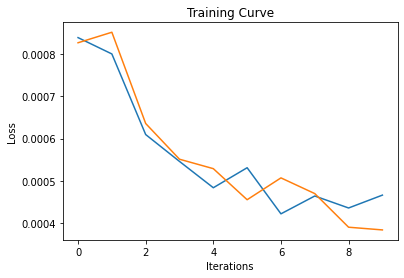
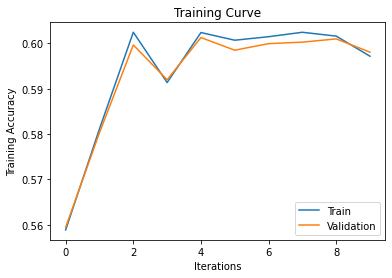

### Part (d) [5 pt]

Tune your hyperparameters, training at least 4 different models (4 sets of hyperparameters).

Do not include all your training curves. Instead, explain what hyperparameters
you tried, what their effect was, and what your thought process was as you 
chose the next set of hyperparameters to try.

#### Tuning:
I decided to tune the following parameters: activation function, hidden units, learning rate, and batch size. I started by deciding a activation function to use, all performed about the same, but tanh(x) performed slightly better than ReLU and sigmoid. Next, I tuned the hidden units in each layer, again most of the parameters I tested performed about the same. But I ended up picking a layering of (47, 37, 27) because it performed well on accuracy and didn't have any stability problems that some of the other layering parameters experienced. Next I tuned the learning rate, I know that the target function is most probably not going to be convex so I chose fairly large learning rates to hopefully allow the model to get out of local minimas and towards a global minima. 0.001 ended up being the best learning rate, it had the highest accuracy and was the most stable. Knowing this, the batch sizes can't be huge, so I chose to test 32, 64, and 128. After testing, I decided to choose a batch size of 128 because it performed equally well as the other two parameters in terms of accuracy but had a better overall loss. Furthermore, a higher batch size will give the model more stability in training.  

Tanh:<br>
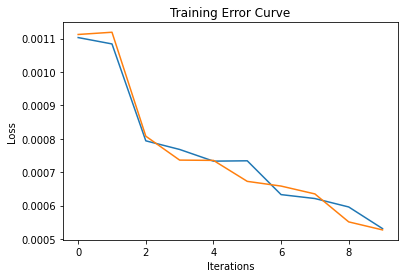
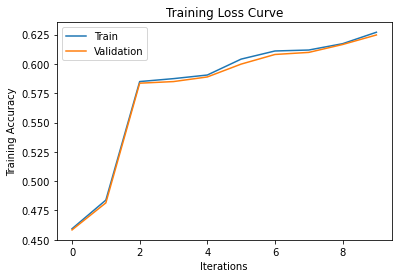

In [ ]:
# Testing activations functions
hyp_act_functions = [[0, 0], [1, 1], [2, 2]]
train_loader, val_loader, test_loader = get_data_loader(batch_size=64)

for actF in hyp_act_functions:
  model = AutoEncoder([40, 32, 16], actF)
  train(model, train_loader, val_loader, num_epochs=10)

Hidden units 47, 37, 27:<br>
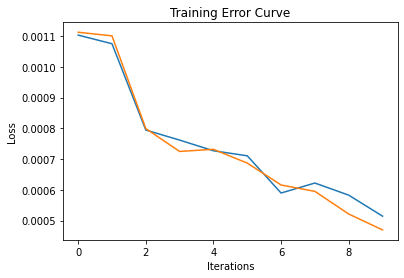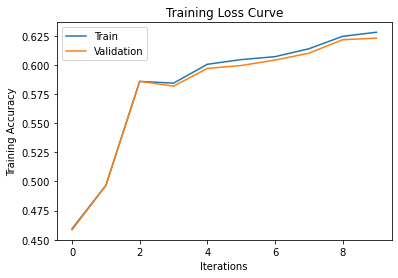

In [ ]:
# Testing changing the number of hidden units
layering = [[35, 20, 15], [47, 37, 27], [30, 20, 10]]

for units in layering:
  model = AutoEncoder(units, [2, 2])
  train(model, train_loader, val_loader, num_epochs=10)

Learning rate 0.01:<br>
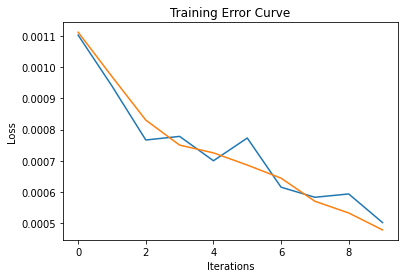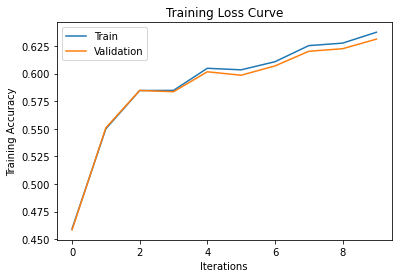

In [ ]:
# Testing learning rate
learning_rate = [0.001, 0.005, 0.0001]
train_loader, val_loader, test_loader = get_data_loader(batch_size=64)

for lr in learning_rate:
  model = AutoEncoder([47, 37, 27], [2, 2])
  train(model, train_loader, val_loader, num_epochs=10, learning_rate=lr)

Batch size 128: <br>
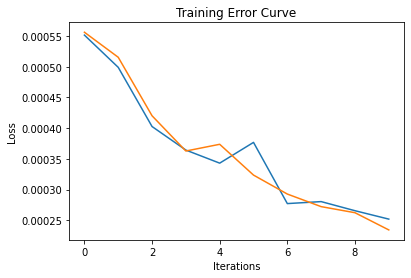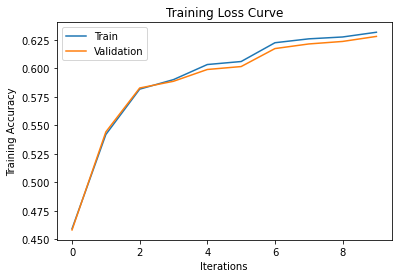

In [ ]:
batch = [32, 64, 128]
train_loader, val_loader, test_loader = get_data_loader(batch_size=64)

for b in batch:
  model = AutoEncoder([47, 37, 27], [2, 2])
  train(model, train_loader, val_loader, num_epochs=10, batch_size=b, learning_rate=0.001)

Final Testing:<br>

*    Hidden units: 47, 37, 27<br>
*    Activation function: Tanh<br>
*    Learning rate: 0.001<br>
*    Batch size: 128<br>


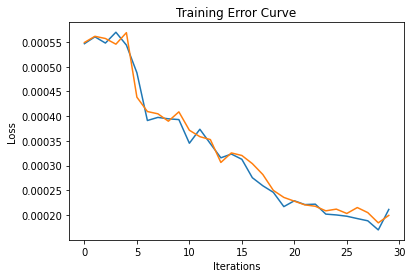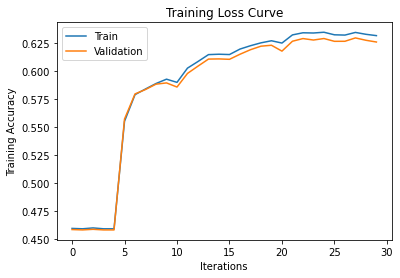

In [ ]:
model = AutoEncoder([47, 37, 27], [2, 2])
train_loader, val_loader, test_loader = get_data_loader(batch_size=128)
train_loss, train_acc, val_loss, val_acc = train(model, train_loader, val_loader, num_epochs=30, batch_size=128, learning_rate=0.001)

## Part 4. Testing [12 pt]

### Part (a) [2 pt]

Compute and report the test accuracy.

Test accuracy: 62.78%

In [ ]:
model = AutoEncoder([47, 37, 27], [2, 2])
train_loader, val_loader, test_loader = get_data_loader(batch_size=128)

checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Model checkpoint/AutoEncoder_lr_0.001_bs_128_epc_30_actf_Tanh.pt')
model.load_state_dict(checkpoint['model_state_dict'])

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

epoch = checkpoint['epoch']
loss = checkpoint['loss']

print(get_accuracy(model, test_loader))

### Part (b) [4 pt]

Based on the test accuracy alone, it is difficult to assess whether our model
is actually performing well. We don't know whether a high accuracy is due to
the simplicity of the problem, or if a poor accuracy is a result of the inherent
difficulty of the problem.

It is therefore very important to be able to compare our model to at least one
alternative. In particular, we consider a simple **baseline**
model that is not very computationally expensive. Our neural network
should at least outperform this baseline model. If our network is not much
better than the baseline, then it is not doing well.

For our data imputation problem, consider the following baseline model:
to predict a missing feature, the baseline model will look at the **most common value** of the feature in the training set. 

For example, if the feature "marriage" is missing, then this model's prediction will be the most common value for "marriage" in the training set, which happens to be "Married-civ-spouse".

What would be the test accuracy of this baseline model?


The baseline model accuracy is about 51.74%

In [22]:
# Get the most common values and save them into an array
columns =["age", "yredu", "capgain", "caploss", "workhr", "work", "marriage", "occupation", "edu", "relationship", "sex"]
most_common_value = []

for col in columns:
  value = df_not_missing[col].value_counts().idxmax()
  most_common_value.append(value)


In [143]:
most_common_value

[0.2602739726027397,
 0.5333333333333333,
 0.0,
 0.0,
 0.3979591836734694,
 ' Private',
 ' Married-civ-spouse',
 ' Prof-specialty',
 ' HS-grad',
 ' Husband',
 ' Male']

In [31]:
# Now calculate the accuracy by checking how many samples have that most  common
# entry...
# EX: How many entries without missing data have 'HS-grad' as there education...
cols_w_mcv = []

for i in range(len(columns)):
  num_w_mcv = len(df[df[columns[i]] == most_common_value[i]])
  cols_w_mcv.append(num_w_mcv)

# Let's use an average accuracy...
samples = df_not_missing.shape[0]
accuracy = 0
for i in cols_w_mcv:
  accuracy += (1.0 / len(cols_w_mcv)) * (i / samples)

print(accuracy)

0.5173247548076638


### Part (c) [1 pt]

How does your test accuracy from part (a) compared to your basline test accuracy in part (b)?

I had a test accuracy of 62.78% which means my model performed 11.95% better than the base line model which achieved a test accuracy of 51.73%.

### Part (d) [1 pt]

Look at the first item in your test data. 
Do you think it is reasonable for a human
to be able to guess this person's education level
based on their other features? Explain.

{<br>
> 'edu': '11th', <br>
> 'marriage': 'Never-married', <br>
> 'occupation': 'Transport-moving', <br>
> 'relationship': 'Own-child', <br>
> 'sex': 'Female', <br>
> 'work': 'Private' <br>

}

Given the above info, I think it's perfectly reasonable for a human to guess this individuals education level. This is because we've grown up and met many people who fall into this exact category, so we can extrapolate and make a reasonable guess about there education status. However, this might be biased by ones perception of a given occupaction, relationship etc... Nevertherless, we've had so much time to learn about what caracteristics we associate with someone who, in this case Transport-moving and has never married, that we should be able to make a reasonable guess and get it correct.

In [204]:
train_loader, val_loader, test_loader = get_data_loader(batch_size=1)

First test index 21870
Training set size:  21502
Validation set size:  4607
Testing set size:  4609


In [205]:
get_features(datanp[21870])

{'edu': '10th',
 'marriage': 'Never-married',
 'occupation': 'Transport-moving',
 'relationship': 'Own-child',
 'sex': 'Female',
 'work': 'Private'}

### Part (e) [2 pt]

What is your model's prediction of this person's education
level, given their other features?


My model incorrectly predicted that this individual is in the 11th grade. Which isn't actually that far off from the real value of 10th grade.

In [203]:
input = torch.from_numpy(datanp[21870])
input = torch.reshape(input, (1, 57))
input = zero_out_feature(input, 'edu')
out = model(input).detach().numpy()

print(get_features(out[0]))

{'work': 'Private', 'marriage': 'Never-married', 'occupation': 'Other-service', 'edu': '11th', 'relationship': 'Own-child', 'sex': 'Female'}


### Part (f) [2 pt]

What is the baseline model's prediction
of this person's education level?

The baseline model predicts that this individual is a high-school grad. Which is wrong, furthermore, it's prediction wasn't as close as my own model. 